In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

from shapely.geometry import Polygon

import iceplant_detection_functions as ipf

In [2]:
from imblearn.over_sampling import SMOTE

In [3]:
#!pip install -U imbalanced-learn
#https://imbalanced-learn.org/stable/install.html#getting-started

# AREAS OF INTEREST

In [11]:
aois = gpd.read_file(os.path.join(os.getcwd(),'areas_of_interest','areas_of_interest.shp'))
cp = aois.iloc[0]  # Campus Lagoon aoi

# ASSEMBLE DATA

All points in the training set were collected in a single NAIP image, 
id = cp.itemid

In [4]:
fp = os.path.join(os.getcwd(),'training_set','aux_data','trainset_trees','trainset_trees.csv')
trees_df = pd.read_csv(fp)
#trees_df.head(1)
trees_df.shape

(395, 9)

In [5]:
fp = os.path.join(os.getcwd(),'training_set','aux_data','trainset_non_iceplant_vegetation.csv')
noniceplant_features_df = pd.read_csv(fp)
#noniceplant_features_df.head(1)
noniceplant_features_df.shape

(193345, 9)

In [6]:
fp = os.path.join(os.getcwd(),'training_set','aux_data','trainset_BIG.csv')
features_df = pd.read_csv(fp)
#features_df.head(1)
features_df.shape

(4789, 9)

In [7]:
# add non-iceplant vegetation points sample to BIG training set 
features_df = pd.concat([features_df,
                         noniceplant_features_df.sample(frac=0.8),
                    #     noniceplant_features_df,
                         trees_df])
features_df.drop(['geometry','Unnamed: 0','x','y'],axis=1,inplace=True)
ipf.iceplant_proportions(features_df.iceplant.to_numpy())

no-iceplant:iceplant ratio     98.4 :1
          counts  percentage
iceplant                    
0         158251       98.99
1           1609        1.01



# SPLIT INTO TRAIN/TEST

In [8]:
train_features, test_features, train_labels, test_labels = ipf.test_train_from_df(features_df)

ipf.train_test_shapes(train_features, train_labels, test_features, test_labels)
ipf.test_train_proportions(train_labels, test_labels)

Training Features Shape: (111902, 4)
Training Labels Shape: (111902,)
Testing Features Shape: (47958, 4)
Testing Labels Shape: (47958,)

TRAIN SET COUNTS:
no-iceplant:iceplant ratio     99.3 :1
          counts  percentage
iceplant                    
0         110786        99.0
1           1116         1.0

TEST SET COUNTS:
no-iceplant:iceplant ratio     96.3 :1
          counts  percentage
iceplant                    
0          47465       98.97
1            493        1.03



# MODEL 1: standard rfc with complete training set
- covariates: r,g, b, nir
- trained on previous set (bigger set than original TRIALS_random forest)

- predictions are only made over NDVI>0.2

In [8]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(train_features,train_labels)

predictions = rfc.predict(test_features)

ipf.print_rfc_evaluation(rfc, test_features, test_labels, predictions)


true negatives: 47387     false positives: 78
false negatives: 126     true positives: 367

sensitivity (TP rate): 74.44 %
specificity (TN rate): 99.84 %
G-mean:  0.86

MCC:  0.7814178860874265

F1-measure:  0.78252
F0.5-measure (min false positives):  0.8073
F2-measure (min false negatives)  :  0.75921

accuracy: 99.57 %



# MODEL: standard rfc with 80% of non_iceplant features

In [9]:

rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(train_features,train_labels)

predictions = rfc.predict(test_features)

ipf.print_rfc_evaluation(rfc, test_features, test_labels, predictions)


true negatives: 47400     false positives: 65
false negatives: 136     true positives: 357

sensitivity (TP/P): 72.41 %
specificity (TN/N): 99.86 %
G-mean:  0.85

MCC:  0.7806239593983282

F1-measure:  0.78033
F0.5-measure (min false positives):  0.81843
F2-measure (min false negatives)  :  0.74561

accuracy: 99.58 %



/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:237: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


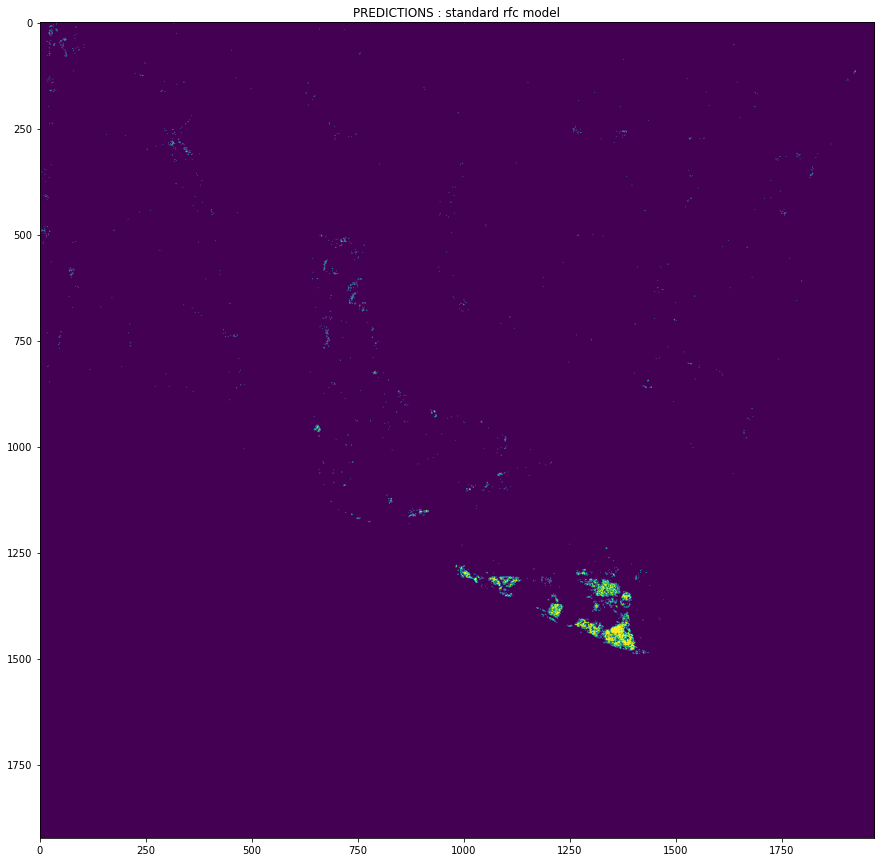

In [12]:
reconstructed = ipf.mask_ndvi_and_predict(cp.itemid, cp.geometry,rfc)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : standard rfc model")
ax.imshow(reconstructed)
plt.show()

# MODEL: standard rfc + SMOTE(10:1)
- covariates: r,g, b, nir
- trained on previous set (bigger set than original TRIALS_random forest)
- SMOTE oversampling used to deal with class imbalance

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html?highlight=smote#imblearn.over_sampling.SMOTE

- predictions are only made over NDVI>0.2

In [13]:
oversample = SMOTE(sampling_strategy=0.1)
over_train_features, over_train_labels = oversample.fit_resample(train_features, train_labels)
ipf.iceplant_proportions(over_train_labels)

no-iceplant:iceplant ratio     10.0 :1
          counts  percentage
iceplant                    
0         110786       90.91
1          11078        9.09



In [14]:
smote_srf = RandomForestClassifier(n_estimators=100, 
                                   random_state=42)
smote_srf.fit(over_train_features, over_train_labels)

smote_predictions = smote_srf.predict(test_features)

ipf.print_rfc_evaluation(smote_srf, test_features, test_labels, smote_predictions)



true negatives: 47311     false positives: 154
false negatives: 89     true positives: 404

sensitivity (TP/P): 81.95 %
specificity (TN/N): 99.68 %
G-mean:  0.9

MCC:  0.7677423274426968

F1-measure:  0.76879
F0.5-measure (min false positives):  0.74128
F2-measure (min false negatives)  :  0.79842

accuracy: 99.49 %



# MODEL: srf +SMOTE(4:1)

In [17]:
oversample = SMOTE(sampling_strategy=0.25)
over_train_features, over_train_labels = oversample.fit_resample(train_features, train_labels)
ipf.iceplant_proportions(over_train_labels)

no-iceplant:iceplant ratio     4.0 :1
          counts  percentage
iceplant                    
0         110786        80.0
1          27696        20.0



In [18]:
smote_srf25 = RandomForestClassifier(n_estimators=100, 
                                   random_state=42)
#Train SMOTE + undersample rfc
smote_srf25.fit(over_train_features, over_train_labels)

smote25_predictions = smote_srf25.predict(test_features)

ipf.print_rfc_evaluation(smote_srf25, test_features, test_labels, smote25_predictions)


true negatives: 47276     false positives: 189
false negatives: 81     true positives: 412

sensitivity (TP/P): 83.57 %
specificity (TN/N): 99.6 %
G-mean:  0.91

MCC:  0.7541486040779359

F1-measure:  0.7532
F0.5-measure (min false positives):  0.71108
F2-measure (min false negatives)  :  0.80062

accuracy: 99.44 %



# MODEL: srf +SMOTE(2:1)

In [20]:
oversample = SMOTE(sampling_strategy=0.5)
over_train_features, over_train_labels = oversample.fit_resample(train_features, train_labels)
ipf.iceplant_proportions(over_train_labels)

no-iceplant:iceplant ratio     2.0 :1
          counts  percentage
iceplant                    
0         110786       66.67
1          55393       33.33



In [21]:
smote_srf5 = RandomForestClassifier(n_estimators=100, 
                                   random_state=42)
#Train SMOTE + undersample rfc
smote_srf5.fit(over_train_features, over_train_labels)

smote5_predictions = smote_srf5.predict(test_features)

ipf.print_rfc_evaluation(smote_srf5, test_features, test_labels, smote5_predictions)


true negatives: 47240     false positives: 225
false negatives: 80     true positives: 413

sensitivity (TP/P): 83.77 %
specificity (TN/N): 99.53 %
G-mean:  0.91

MCC:  0.7333582243389917

F1-measure:  0.73033
F0.5-measure (min false positives):  0.67816
F2-measure (min false negatives)  :  0.79119

accuracy: 99.36 %



In [12]:
# create test and train sets with SMOTE
from imblearn.under_sampling import RandomUnderSampler
#from sklearn.pipeline import Pipeline
#labels = np.array(features_df['iceplant'])
#features = np.array(features_df.drop('iceplant', axis = 1))

oversample = SMOTE(sampling_strategy=0.1)
#undersample = RandomUnderSampler(sampling_strategy=0.5)

#steps = [('o', oversample), ('u', undersample)]
#pipeline = Pipeline(steps=steps)

over_train_features, over_train_labels = oversample.fit_resample(train_features, train_labels)
#over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.1, stratify=over_y)
#print(over_train_features.shape)
#print(over_train_labels.shape)
ipf.iceplant_proportions(over_train_labels)

no-iceplant:iceplant ratio     10.0 :1
          counts  percentage
iceplant                    
0         110786       90.91
1          11078        9.09



In [14]:
undersample = RandomUnderSampler(sampling_strategy=0.5)
under_train_features, under_train_labels = undersample.fit_resample(over_train_features, over_train_labels)

ipf.iceplant_proportions(under_train_labels)

no-iceplant:iceplant ratio     2.0 :1
          counts  percentage
iceplant                    
0          22156       66.67
1          11078       33.33



In [15]:
# ------------------------------------------------------------------------------------------

resample_SRF = RandomForestClassifier(n_estimators=100, 
                                   random_state=42)
#Train SMOTE + undersample rfc
resample_SRF.fit(under_train_features, under_train_labels)

RandomForestClassifier(random_state=42)

In [16]:
resample_predictions = resample_SRF.predict(test_features)

ipf.print_rfc_evaluation(resample_SRF, test_features, test_labels, resample_predictions)


true negatives: 47001     false positives: 464
false negatives: 48     true positives: 445

sensitivity (TP rate): 90.26 %
specificity (TN rate): 99.02 %
G-mean:  0.95

MCC:  0.6604456102004729

F1-measure:  0.63481
F0.5-measure (min false positives):  0.53887
F2-measure (min false negatives)  :  0.7723

accuracy: 98.93 %



/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:237: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


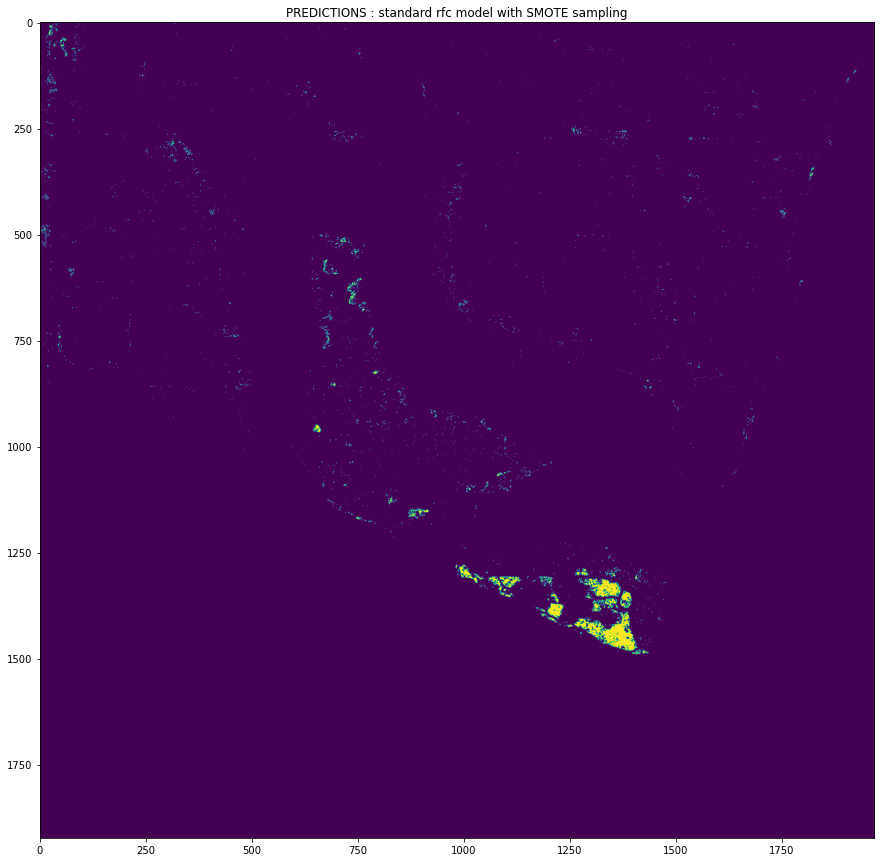

In [19]:
predictions = ipf.mask_ndvi_and_predict(cp.itemid, cp.geometry, resample_SRF)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : standard rfc model with SMOTE sampling")
ax.imshow(predictions)
plt.show()

# MODEL: balanced rfc + SMOTE(10:1)

In [16]:
smote_brf = RandomForestClassifier(n_estimators=100,
                                   class_weight = 'balanced',
                                   random_state=42)
#Train SMOTE + undersample rfc
smote_brf.fit(over_train_features, over_train_labels)

smote_predictions = smote_brf.predict(test_features)

ipf.print_rfc_evaluation(smote_brf, test_features, test_labels, smote_predictions)


true negatives: 47315     false positives: 150
false negatives: 92     true positives: 401

sensitivity (TP/P): 81.34 %
specificity (TN/N): 99.68 %
G-mean:  0.9

MCC:  0.7668668865085896

F1-measure:  0.7682
F0.5-measure (min false positives):  0.74342
F2-measure (min false negatives)  :  0.79469

accuracy: 99.5 %



# MODEL 3: rfc with class weighting
- class_weight = balanced in rfc model

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [19]:
rfc_balanced = RandomForestClassifier(n_estimators = 100, 
                                      random_state = 42,
                                      class_weight='balanced')
rfc_balanced.fit(train_features,train_labels)
predictions_balanced = rfc_balanced.predict(test_features)
ipf.print_rfc_evaluation(rfc_balanced, test_features, test_labels, predictions_balanced)


true negatives: 47404     false positives: 61
false negatives: 139     true positives: 354

sensitivity (TP/P): 71.81 %
specificity (TN/N): 99.87 %
G-mean:  0.85

MCC:  0.7805868247627925

F1-measure:  0.77974
F0.5-measure (min false positives):  0.82211
F2-measure (min false negatives)  :  0.74152

accuracy: 99.58 %



In [ ]:
reconstructed = ipf.mask_ndvi_and_predict(cp.itemid, cp.geometry, rfc_balanced)

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(reconstructed)
plt.show()

# **** MOVE THESE TO ANOTHER NOTEBOOK ****

In [ ]:
lagoon_zoom = ipf.mask_ndvi_and_predict(itemid, lagoon_zoom_box,rfc)
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(lagoon_zoom)
plt.show()

In [ ]:
ipf.plot_window_in_scene(itemid, lagoon_zoom_box)

In [ ]:
tree_predict = ipf.mask_ndvi_and_predict(itemid, tree_box, rfc)
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(tree_predict)
plt.show()

In [ ]:
tree_ndvi = ipf.select_ndvi_image(itemid,tree_box)
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.imshow(tree_ndvi)
# plt.show()

In [ ]:
true_tree = tree_ndvi - tree_predict
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(true_tree)
plt.show()

In [ ]:
tree_naip = ipf.open_window_in_scene(itemid, tree_box)

In [ ]:
p = (tree_naip*tree_predict).reshape([4,-1]).T
p = pd.DataFrame(p, columns =['r','g','b','nir'])
df = p[(p.r!=0) & (p.g!=0) & (p.b!=0) & (p.nir!=0)]
df['classified']=1
df

In [ ]:
icep_predict = tree_naip*true_tree
p = icep_predict.reshape([4,-1]).T
p = pd.DataFrame(p, columns =['r','g','b','nir'])
df2 = p[(p.r!=0) & (p.g!=0) & (p.b!=0) & (p.nir!=0)]
df2['classified']=0
df2

In [ ]:
df = pd.concat([df,df2])
df

In [ ]:
dangermond = ipf.mask_ndvi_and_predict(dangermond_itemid, dangermond_box,rfc_balanced)
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(dangermond)
plt.show()

In [ ]:
ipf.plot_window_in_scene(dangermond_itemid, dangermond_box)